### 필요한 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")

### 학습 데이터 생성
- 사인(Sine) 함수를 이용해 데이터 생성

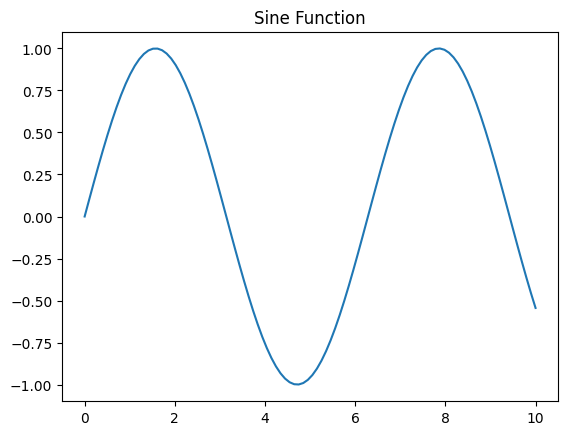

In [3]:
data_size = 100

data_x = np.linspace(0, 10, data_size) # 0부터 10까지 100개의 포인트 설정
data_y = np.sin(data_x) #각 포인트에 대한 Sine값 계산

plt.title("Sine Function")
plt.plot(data_x, data_y)
plt.show()

In [9]:
sequence_size = 5
train_size = data_size - sequence_size

train_X = []
train_Y = []

for i in range(0, train_size):
  train_X.append(data_y[i:i + sequence_size]) #앞의 5개가 주어졌을때,
  train_Y.append(data_y[i + sequence_size]) # 다음 값을 맞추는 문제

train_X = np.array(train_X)
train_Y = np.array(train_Y)

# [시퀀스의 개수(배치 크기), 시퀀스 길이]
print(train_X.shape)
print(train_Y.shape)

train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y)

# PyTorch에서 사용할 수 있는 형태로 변환 후에 GPU로 옮기기
#RNN 에서는 (시퀀스의 길이, 배치크기, 입력특징수)로 input 을 넣어주어야함.
train_X = torch.transpose(train_X, 0, 1).unsqueeze(2).float().to(device)
train_Y = train_Y.unsqueeze(1).float().to(device)

print(train_X.shape) # [시퀀스 길이(크기), 시퀀스 개수, 1]
print(train_Y.shape)

(95, 5)
(95,)
torch.Size([5, 95, 1])
torch.Size([95, 1])


### RNN 모델 정의하기
- 하이퍼 파라미터를 설정
- RNN 모델을 정의

In [13]:
input_dim = 1
output_dim = 1
hidden_dim = 1000

In [17]:
class RNN(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(RNN, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim

    self.rnn = nn.RNN(self.input_dim, self.hidden_dim)
    self.w_hy = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, x, h):
    outputs, hidden = self.rnn(x, h) # x: [seq_len, batch, input_size], h: [num_layers, batch, hidden_size]
    # PyTorch의 RNN의 outputs은 모든 결과를 가지고 있으며 hidden은 마지막 context vector를 의미
    # 현재 예제에서는 context vector를 사용하지 않음 (기계 번역 등에서는 사용)
    y = self.w_hy(outputs[-1].unsqueeze(0)) # 하나의 결과를 찾는 회귀(regression) 문제이므로 마지막 원소를 확인
    return y, outputs

### RNN 모델 학습하기
- RNN 모델을 학습합니다.

In [18]:
# 현재 모델의 출력을 확인
def show(rnn):
    rnn.eval()
    predictions = []

    # 현재 예제에서는 [레이어 수 = 1, 학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, train_size, hidden_dim).to(device)

    # 전체 시퀀스 데이터를 한꺼번에 넣기
    y_pred, h = rnn(train_X, h)

    plt.title("Prediction Result")
    plt.plot(data_x[sequence_size:], data_y[sequence_size:])
    plt.plot(data_x[sequence_size:], y_pred.view(-1).cpu().detach().numpy())
    plt.legend(["Real", "Predicted"])
    plt.show()

[ Training Start ]


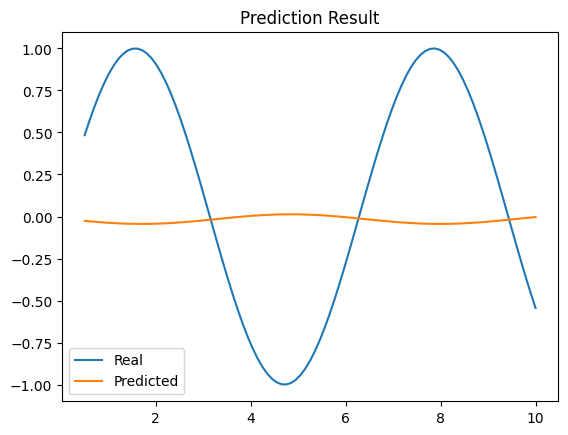

[1000/10000] loss = 1.9894206104709156e-07


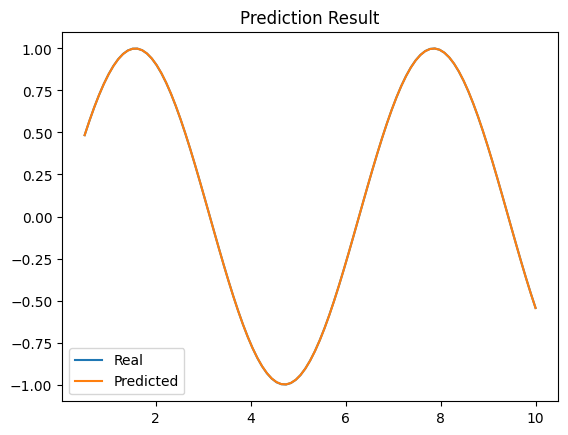

[2000/10000] loss = 1.9865160538756754e-07


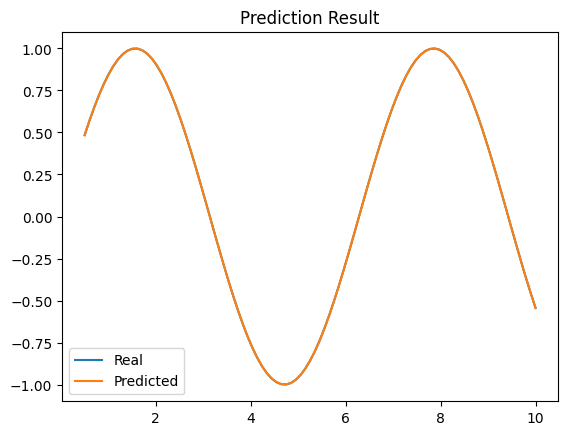

[3000/10000] loss = 1.98375047943955e-07


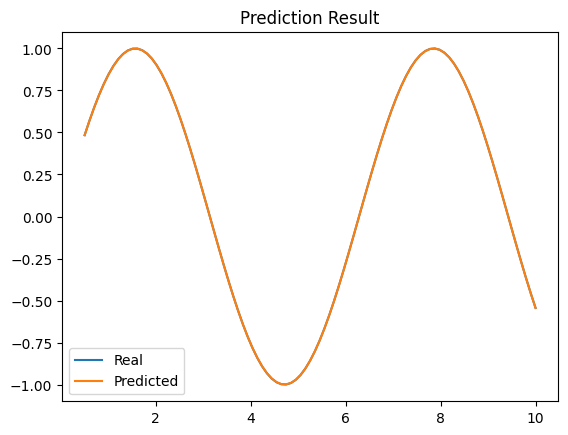

[4000/10000] loss = 1.9809182560948102e-07


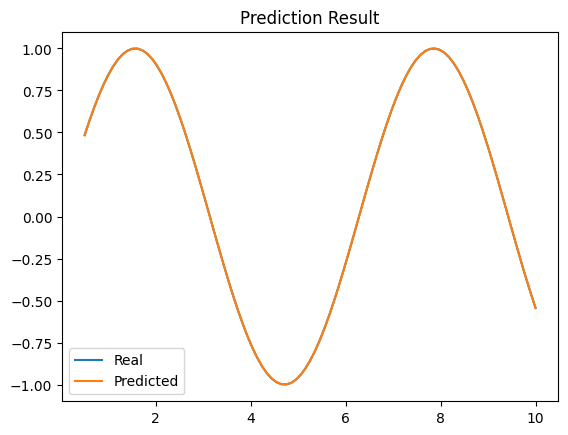

[5000/10000] loss = 1.9781094806603505e-07


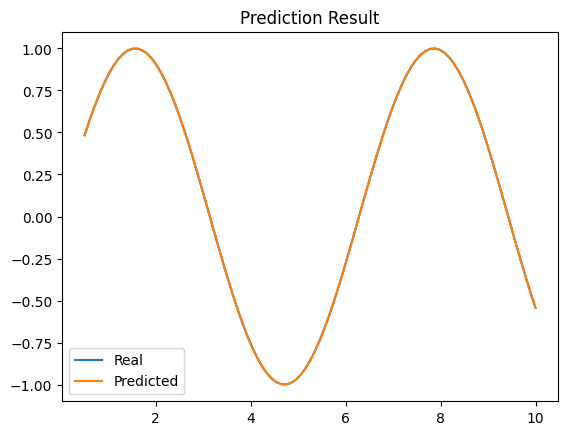

[6000/10000] loss = 1.9752751256874035e-07


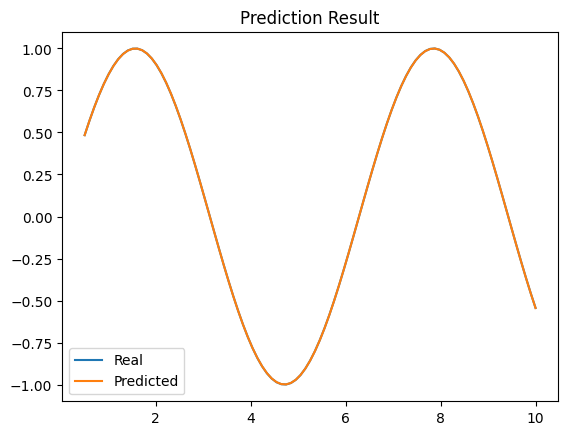

[7000/10000] loss = 1.972554315443631e-07


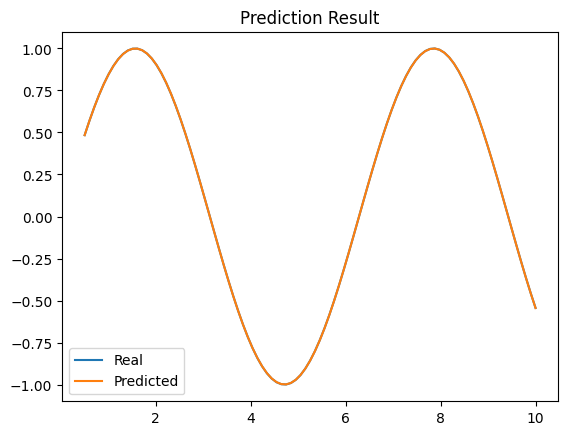

[8000/10000] loss = 1.9698271103152365e-07


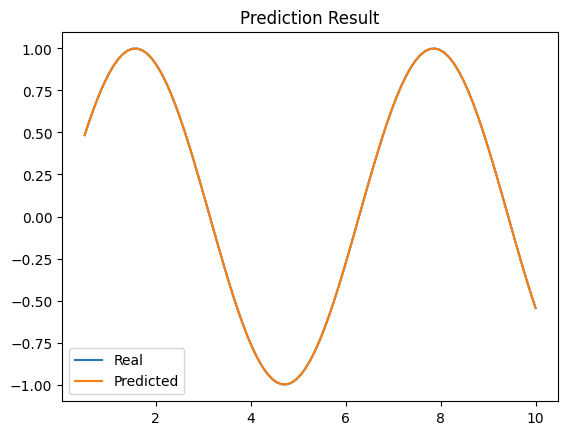

[9000/10000] loss = 1.967092373433843e-07


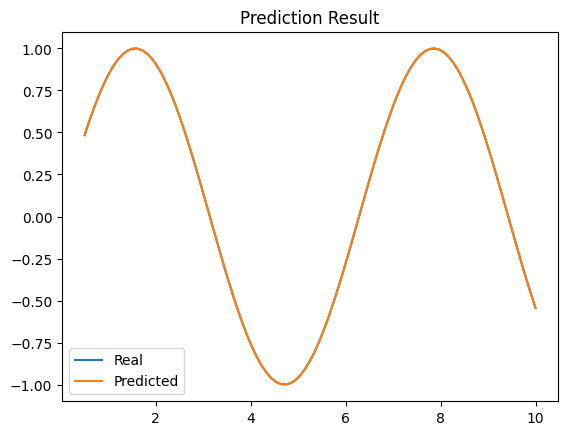

[10000/10000] loss = 1.964445033308948e-07


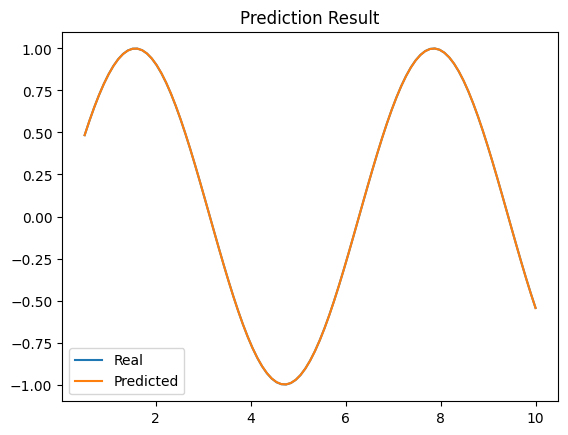

In [19]:
rnn = RNN(input_dim, output_dim, hidden_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005, momentum=0.9)

print("[ Training Start ]")
show(rnn)

epoch = 10000

for i in range(epoch):
    rnn.train()
    rnn.zero_grad()
    optimizer.zero_grad()

    # 현재 예제에서는 [레이어 수 = 1, 학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, train_size, hidden_dim).to(device)

    # 전체 시퀀스 데이터를 한꺼번에 넣기
    y_pred, h = rnn(train_X, h)

    # 손실(loss) 값을 계산하여 학습 진행
    loss = loss_fn(train_Y, y_pred.squeeze(0))
    loss.backward()
    optimizer.step()

    if (i + 1) % 1000 == 0:
        print(f"[{i + 1}/{epoch}] loss = {loss.item()}")
        show(rnn)

### 자동으로 결과 예측해보기
- 초반의 데이터만 입력한 상태에서 앞으로의 모든 결과를 예측

In [20]:
# 평가를 위한 하나의 시퀀스 생성
test_X = train_X[:, 0, :].unsqueeze(2)
print(test_X.shape)

rnn.eval()
predictions = []

for i in range(1000):
    # 현재 예제에서는 [레이어 수 = 1, 평가 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, 1, hidden_dim).to(device)

    # 전체 시퀀스 데이터를 한꺼번에 넣기
    y_pred, h = rnn(test_X, h)

    test_X = torch.cat((test_X, y_pred), dim=0)[1:]
    # torch.cat은 주어진 차원에 따라 여러 텐서를 연결하는 함수입니다. 여기서는 dim=0에 대해 test_X와 y_pred를 연결하고 있습니다.
    # 예를 들어, 만약 test_X의 형태가 (5, 1, 1)이고, y_pred의 형태가 (1, 1, 1)이라고 하면, torch.cat 후의 결과는 (6, 1, 1)의 형태를 가집니다.
    # 즉, y_pred가 test_X의 끝에 추가됩니다.
    # 인덱싱 [1:]
    # 이 부분은 torch.cat으로 연결된 텐서에서 첫 번째 원소(시퀀스의 첫번째 타임스탭)를 제거하는 역할을 합니다. 결과적으로 텐서의 크기는 다시 (5, 1, 1)로 돌아옵니다.
    # 이렇게 하는 이유는 예측 과정에서 최신 예측값(y_pred)을 test_X에 추가하고, 가장 오래된 값(시퀀스의 첫번째 값)을 제거하여 다음 예측의 입력으로 사용하기 위함입니다. 이를 통해 시퀀스 내의 정보를 계속해서 업데이트하며 새로운 예측을 생성합니다.
    # 결과적으로, 이 코드는 test_X에 최신 예측값을 추가하고, 가장 오래된 값을 제거하는 방식으로 test_X를 갱신합니다.
    predictions.append(y_pred.item())

torch.Size([5, 1, 1])


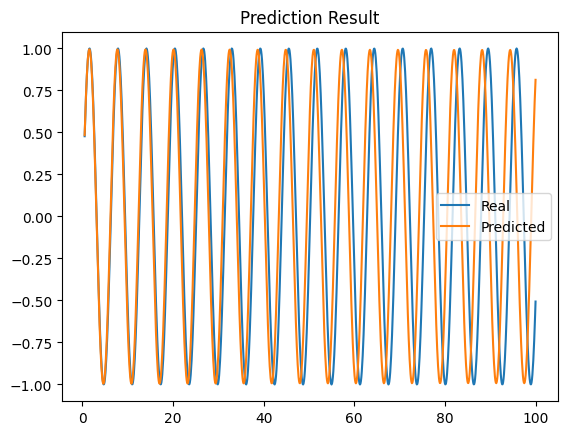

In [21]:
test_x = np.linspace(0, 100, 1000 + sequence_size)
test_y = np.sin(test_x) # 각 포인트에 대한 sine() 값 계산

plt.title("Prediction Result")
plt.plot(test_x[sequence_size:], test_y[sequence_size:])
plt.plot(test_x[sequence_size:], predictions)
plt.legend(["Real", "Predicted"])
plt.show()
